In [1]:
# ✓ Setup: Point to data folder in TeamX/src/data
from pathlib import Path
import os

# Get the notebook's actual directory location
notebook_file = Path(__file__) if '__file__' in dir() else Path.cwd() / 'Image_Classifier_Training.ipynb'

# For Jupyter: Get parent directory of notebook
# Notebook location: .../TeamX/src/Image_Classifier_Training.ipynb
# Expected data location: .../TeamX/src/data/

# Try to locate notebook by searching for it in common paths
possible_paths = [
    Path(r"c:\Users\skido\OneDrive\Desktop\NUS-ISS\Sem 2\SA4110 Machine Learning Application Development [2510]\ML-CA-Image-Classifier-V1.0\ML-CA-Image-Classifier-V1.0\TeamX\src"),
    Path.cwd(),
    Path.cwd() / 'src',
    Path.cwd().parent / 'src'  # Handle case where running from TeamX directory
]

notebook_dir = None
for path in possible_paths:
    if (path / 'Image_Classifier_Training.ipynb').exists() or (path / 'data').exists():
        notebook_dir = path
        break

if notebook_dir is None:
    # Fallback to absolute path
    notebook_dir = Path(r"c:\Users\skido\OneDrive\Desktop\NUS-ISS\Sem 2\SA4110 Machine Learning Application Development [2510]\ML-CA-Image-Classifier-V1.0\ML-CA-Image-Classifier-V1.0\TeamX\src")

data_dir = notebook_dir / 'data'

print(f"✓ Notebook directory: {notebook_dir}")
print(f"✓ Data folder: {data_dir}")
print(f"✓ Data exists: {data_dir.exists()}")

if data_dir.exists():
    train_path = data_dir / 'train'
    test_path = data_dir / 'test'
    print(f"  - train/ exists: {train_path.exists()}")
    print(f"  - test/ exists: {test_path.exists()}")
    if train_path.exists():
        train_images = len(list(train_path.glob('*.jpg'))) + len(list(train_path.glob('*.png')))
        print(f"  - train images: {train_images}")
    if test_path.exists():
        test_images = len(list(test_path.glob('*.jpg'))) + len(list(test_path.glob('*.png')))
        print(f"  - test images: {test_images}")
else:
    print(f"⚠️  WARNING: Data folder not found at {data_dir}")
    print(f"   Please ensure train/ and test/ folders exist in the data directory")

✓ Notebook directory: c:\Users\skido\OneDrive\Desktop\NUS-ISS\Sem 2\SA4110 Machine Learning Application Development [2510]\ML-CA-Image-Classifier-V1.0\ML-CA-Image-Classifier-V1.0\TeamX\src
✓ Data folder: c:\Users\skido\OneDrive\Desktop\NUS-ISS\Sem 2\SA4110 Machine Learning Application Development [2510]\ML-CA-Image-Classifier-V1.0\ML-CA-Image-Classifier-V1.0\TeamX\src\data
✓ Data exists: True
  - train/ exists: True
  - test/ exists: True
  - train images: 647
  - test images: 60


# Image Classifier Training Pipeline
## CNN-based Fruit Classifier with Comprehensive Improvements

This notebook demonstrates a complete machine learning pipeline addressing all project requirements:

**Project Requirement 1**: Create a CNN model to classify 4 fruit types
- ✅ Uses MobileNetV2 (CNN-based transfer learning)
- ✅ Classifies: Apple, Orange, Banana, Mixed

**Project Requirement 2-3**: Use Train.zip and Test.zip datasets
- ✅ Training: 240 images from data/train/
- ✅ Testing: 60 images from data/test/

**Project Requirement 4**: Document experiments and results
- ✅ Comprehensive experiment documentation with timestamps
- ✅ Performance metrics, plots, and analysis

**Project Requirement 5**: Apply improvement techniques
- ✅ **Class Balancing**: Balanced weights for imbalanced categories
- ✅ **Mislabel Detection**: Identify and report suspicious/mislabeled images
- ✅ **Data Augmentation**: Rotation, zoom, brightness, shifts, flips

**Project Requirement 6**: Generate explanatory plots
- ✅ Training history (accuracy & loss curves)
- ✅ Confusion matrix for error analysis
- ✅ Per-class accuracy breakdown

## Step 1: Import Required Libraries

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np

## Step 2: Create Data Augmentation Generators

The "Confusion" Generator creates new variations of your training photos on the fly to help the model learn better.

In [3]:
# --- 1. DATA AUGMENTATION (The "Confusion" Generator) ---
# This creates new variations of your photos on the fly.
# Support train/validation split via subset parameter
# OPTIMIZATION: ENHANCED augmentation for 92%+ accuracy
train_datagen = ImageDataGenerator(
    rescale=1./255,                    # Normalize pixel values
    rotation_range=50,                 # ENHANCED: ±50° (was ±45°)
    width_shift_range=0.3,             # ENHANCED: ±30% (was ±25%)
    height_shift_range=0.3,            # ENHANCED: ±30% (was ±25%)
    shear_range=0.3,                   # ENHANCED: ±30% (was ±25%)
    zoom_range=0.4,                    # ENHANCED: ±40% (was ±30%)
    horizontal_flip=True,              # Mirror image
    vertical_flip=True,                # Allow vertical flips
    brightness_range=[0.6, 1.4],       # ENHANCED: 0.6-1.4x (was 0.7-1.3x)
    channel_shift_range=40.0,          # ENHANCED: 40 (was 30)
    fill_mode='reflect',               # reflect for better edge handling
    validation_split=0.1               # Reserve 10% of training data for validation
)

# Test data should NOT be augmented, only scaled.
# Test data will NOT be used during training - only for final evaluation
test_datagen = ImageDataGenerator(rescale=1./255)

print("✓ Data augmentation generators created (ENHANCED for 92%+)!")
print("\n📊 ENHANCED Augmentation Parameters (for 92%+ accuracy):")
print("  - Rotation: ±50° (improved from ±45°)")
print("  - Shift: ±30% (improved from ±25%)")
print("  - Zoom: ±40% (improved from ±30%)")
print("  - Shear: ±30° (improved from ±25°)")
print("  - Vertical flip: Enabled")
print("  - Brightness: 0.6 - 1.4x (improved from 0.7-1.3x)")
print("  - Channel shift: 40 (improved from 30)")
print("  - Fill mode: reflect (better edge handling)")

✓ Data augmentation generators created (ENHANCED for 92%+)!

📊 ENHANCED Augmentation Parameters (for 92%+ accuracy):
  - Rotation: ±50° (improved from ±45°)
  - Shift: ±30% (improved from ±25%)
  - Zoom: ±40% (improved from ±30%)
  - Shear: ±30° (improved from ±25°)
  - Vertical flip: Enabled
  - Brightness: 0.6 - 1.4x (improved from 0.7-1.3x)
  - Channel shift: 40 (improved from 30)
  - Fill mode: reflect (better edge handling)


## Step 3: Load Data Generators

Load training and test data from directory structure with augmentation applied.

In [4]:
# Data is stored flat with class prefixes (e.g., apple_1.jpg, banana_1.jpg)
# Organize into class subdirectories for flow_from_directory()

from pathlib import Path
import shutil

# Use notebook_dir from setup cell, then navigate to data subfolder
notebook_src_dir = notebook_dir  # This is .../TeamX/src
data_dir = notebook_src_dir / 'data'  # This is .../TeamX/src/data
train_path = data_dir / 'train'
test_path = data_dir / 'test'

print(f"Train path: {train_path}")
print(f"Train exists: {train_path.exists()}")
print(f"Test exists: {test_path.exists()}")

if train_path.exists():
    train_images = list(train_path.glob('*.jpg')) + list(train_path.glob('*.png'))
    print(f"Train images found: {len(train_images)}")
else:
    print(f"⚠️  ERROR: Train path does not exist: {train_path}")

# Create organized subdirectory structure
train_organized = train_path / 'organized'
test_organized = test_path / 'organized'

# Always reorganize to pick up new data
print("\n📁 Organizing images into class subdirectories...")

classes = ['apple', 'banana', 'orange', 'mixed']

# Clear old organized data if it exists - with error handling for Windows permission issues
def safe_rmtree(path):
    """Remove directory tree with robust error handling for Windows lock issues."""
    if not path.exists():
        return
    
    import time
    max_retries = 3
    for attempt in range(max_retries):
        try:
            # Try to close any open file handles first
            import gc
            gc.collect()
            time.sleep(0.1)
            
            # Remove with ignore_errors to handle locked files
            shutil.rmtree(path, ignore_errors=True)
            
            # Verify removal
            if not path.exists():
                return True
            
            # If directory still exists, try more aggressive approach
            import os
            for root, dirs, files in os.walk(path, topdown=False):
                for name in files:
                    try:
                        os.remove(os.path.join(root, name))
                    except:
                        pass
                for name in dirs:
                    try:
                        os.rmdir(os.path.join(root, name))
                    except:
                        pass
            
            return True
        except Exception as e:
            if attempt < max_retries - 1:
                time.sleep(0.5)
                continue
            else:
                print(f"Warning: Could not fully clear {path}: {e}")
                return False

if train_organized.exists():
    print("  - Clearing previous training organization...")
    safe_rmtree(train_organized)
if test_organized.exists():
    print("  - Clearing previous test organization...")
    safe_rmtree(test_organized)

# Organize training data
print("\nOrganizing training data...")
train_class_counts = {}
for cls in classes:
    (train_organized / cls).mkdir(parents=True, exist_ok=True)
    cls_files = sorted(list(train_path.glob(f'{cls}_*.jpg')) + list(train_path.glob(f'{cls}_*.png')))
    train_class_counts[cls] = len(cls_files)
    for file in cls_files:
        shutil.copy2(file, train_organized / cls / file.name)
    print(f"  ✓ {cls}: {len(cls_files)} images")

# Organize test data
print("\nOrganizing test data...")
test_class_counts = {}
for cls in classes:
    (test_organized / cls).mkdir(parents=True, exist_ok=True)
    cls_files = sorted(list(test_path.glob(f'{cls}_*.jpg')) + list(test_path.glob(f'{cls}_*.png')))
    test_class_counts[cls] = len(cls_files)
    for file in cls_files:
        shutil.copy2(file, test_organized / cls / file.name)
    print(f"  ✓ {cls}: {len(cls_files)} images")

print("\n✓ Data organized successfully!")
print(f"\n📊 Data Summary:")
print(f"  Training: {sum(train_class_counts.values())} total images")
print(f"  Test: {sum(test_class_counts.values())} total images")

# Load from organized structure with 150x150 (matches best model)
# IMPORTANT: Split training data into train/validation (80/20)
# Test data kept completely separate for final evaluation ONLY
print("\n" + "="*70)
print("Loading Data Generators (150x150 - matches best model)...")
print("="*70 + "\n")

# Create train/validation split from training data ONLY
# This keeps test data completely untouched until final evaluation
print("📊 Data Split Strategy:")
print("   - Training data (90%): Used for model training")
print("   - Validation data (10%): Used to monitor overfitting during training")
print("   - Test data: Kept completely separate for final evaluation ONLY")
print()

train_generator = train_datagen.flow_from_directory(
    str(train_organized),
    target_size=(150, 150),
    batch_size=16,
    class_mode='categorical',
    shuffle=True,
    subset='training'  # 90% of data for training
)

validation_generator = train_datagen.flow_from_directory(
    str(train_organized),
    target_size=(150, 150),
    batch_size=16,
    class_mode='categorical',
    shuffle=False,
    subset='validation'  # 10% of data for validation
)

# Test data generator - loaded but NOT used during training
test_generator = test_datagen.flow_from_directory(
    str(test_organized),
    target_size=(150, 150),
    batch_size=16,
    class_mode='categorical'
)

print(f"✓ Data generators loaded successfully!")
print(f"\nTraining data (90% of train/):")
print(f"  - Batches: {len(train_generator)}")
print(f"  - Classes: {list(train_generator.class_indices.keys())}")

print(f"\nValidation data (10% of train/):")
print(f"  - Batches: {len(validation_generator)}")
print(f"  - Classes: {list(validation_generator.class_indices.keys())}")

print(f"\nTest data (kept separate for final evaluation):")
print(f"  - Batches: {len(test_generator)}")
print(f"  - Classes: {list(test_generator.class_indices.keys())}")
print(f"  - Status: 🔒 NOT USED DURING TRAINING - ONLY for final evaluation")

Train path: c:\Users\skido\OneDrive\Desktop\NUS-ISS\Sem 2\SA4110 Machine Learning Application Development [2510]\ML-CA-Image-Classifier-V1.0\ML-CA-Image-Classifier-V1.0\TeamX\src\data\train
Train exists: True
Test exists: True
Train images found: 647

📁 Organizing images into class subdirectories...
  - Clearing previous training organization...
  - Clearing previous test organization...

Organizing training data...
  ✓ apple: 148 images
  ✓ banana: 169 images
  ✓ orange: 166 images
  ✓ mixed: 164 images

Organizing test data...
  ✓ apple: 19 images
  ✓ banana: 18 images
  ✓ orange: 18 images
  ✓ mixed: 5 images

✓ Data organized successfully!

📊 Data Summary:
  Training: 647 total images
  Test: 60 total images

Loading Data Generators (150x150 - matches best model)...

📊 Data Split Strategy:
   - Training data (90%): Used for model training
   - Validation data (10%): Used to monitor overfitting during training
   - Test data: Kept completely separate for final evaluation ONLY

Found

## Step 4: Compute Class Weights

Handle imbalanced data by computing weights that penalize the model more heavily for mistakes on underrepresented classes.

In [5]:
# Compute class weights to handle imbalanced data
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weight_dict = dict(enumerate(class_weights))

# Count actual images (using generator.classes which has all labels)
train_count = len(train_generator.classes)
test_count = len(test_generator.classes)

print("✓ Class weights computed!")
print(f"✓ Class weight dictionary: {class_weight_dict}")
print(f"\nTraining samples: {train_count}")
print(f"✓ Test samples: {test_count}")
print(f"✓ Classes: {list(train_generator.class_indices.keys())}")

✓ Class weights computed!
✓ Class weight dictionary: {0: np.float64(1.0914179104477613), 1: np.float64(0.9558823529411765), 2: np.float64(0.9881756756756757), 3: np.float64(0.975)}

Training samples: 585
✓ Test samples: 60
✓ Classes: ['apple', 'banana', 'mixed', 'orange']


## Step 5: Build Model Architecture

Create a **MobileNetV2 transfer learning model** with pre-trained ImageNet weights and fine-tuned top layers for fruit classification.

In [27]:
# --- 3. ARCHITECTURE (Transfer Learning with MobileNetV2) ---
# Key insight: With limited data (240 samples), transfer learning from ImageNet
# pre-trained weights gives much better accuracy than training from scratch
# OPTIMIZATION: Enhanced fine-tuning + Aggressive regularization for 92%+ accuracy

# Load pre-trained MobileNetV2 base model
base_model = MobileNetV2(
    input_shape=(150, 150, 3),
    include_top=False,
    weights='imagenet'
)

# OPTIMIZATION: Unfreeze last 20 layers for more aggressive fine-tuning
# More layers trainable = better adaptation to fruit classification
for layer in base_model.layers[:-20]:
    layer.trainable = False
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Build model with custom head for 4 fruit classes
# OPTIMIZATION: More aggressive regularization for 92%+ accuracy
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.7))  # ENHANCED: 0.7 (was 0.6)
model.add(Dense(768, activation='relu', kernel_regularizer='l2'))  # ENHANCED: 768 units (was 512)
model.add(BatchNormalization())
model.add(Dropout(0.6))  # ENHANCED: 0.6 (was 0.5)
model.add(Dense(384, activation='relu', kernel_regularizer='l2'))  # ENHANCED: 384 units (was 256)
model.add(BatchNormalization())
model.add(Dropout(0.5))  # ENHANCED: 0.5 (was 0.4)
model.add(Dense(128, activation='relu', kernel_regularizer='l2'))  # NEW: Additional dense layer
model.add(BatchNormalization())
model.add(Dropout(0.3))  # NEW: Additional dropout
model.add(Dense(4, activation='softmax'))

# Compile the model with even lower learning rate for fine-tuning
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.00005),  # ENHANCED: 0.00005 (was 0.0001) - even more conservative
    metrics=['accuracy']
)

print("✓ Transfer Learning model created with ENHANCED MobileNetV2 (92%+ target)!")
print("✓ Base: Pre-trained on 1.4M ImageNet images (last 20 layers trainable - ENHANCED)")
print("✓ Head: GlobalAveragePooling2D → Dense(768) + L2 → Dense(384) + L2 → Dense(128) + L2 → Dense(4)")
print("✓ Regularization: L2 + AGGRESSIVE Dropout (0.7 → 0.6 → 0.5 → 0.3)")
print("✓ Learning rate: 0.00005 (even more conservative for fine-tuning)")
print("✓ Expected accuracy: 92%+ (improved from current 90%)")
print("\nModel Architecture:")
model.summary()

C:\Users\skido\AppData\Local\Temp\ipykernel_31216\748753449.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


✓ Transfer Learning model created with ENHANCED MobileNetV2 (92%+ target)!
✓ Base: Pre-trained on 1.4M ImageNet images (last 20 layers trainable - ENHANCED)
✓ Head: GlobalAveragePooling2D → Dense(768) + L2 → Dense(384) + L2 → Dense(128) + L2 → Dense(4)
✓ Regularization: L2 + AGGRESSIVE Dropout (0.7 → 0.6 → 0.5 → 0.3)
✓ Learning rate: 0.00005 (even more conservative for fine-tuning)
✓ Expected accuracy: 92%+ (improved from current 90%)

Model Architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 768)            │       983,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 768)            │         3,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 384)            │       295,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 384)            │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,592,004 (13.70 MB)

 Trainable params: 2,537,540 (9.68 MB)

 Non-trainable params: 1,054,464 (4.02 MB)

## Step 6: Setup Training Callbacks

Configure callbacks for:
- Early stopping (prevent overfitting)
- Learning rate reduction (adaptive learning)
- Model checkpointing (save best model)

In [28]:
# Create experiment directory with timestamp
from datetime import datetime

# Use notebook directory as base for experiments folder
experiment_base = notebook_src_dir.parent / 'experiments'  # .../TeamX/experiments
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
experiment_dir = experiment_base / f"notebook_{timestamp}"
experiment_dir.mkdir(parents=True, exist_ok=True)

# OPTIMIZATION: ENHANCED callbacks for 92%+ accuracy (more aggressive)
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,  # ENHANCED: 15 (was 10 - allow even more epochs for convergence)
        restore_best_weights=True,
        verbose=1,
        min_delta=0.001  # ENHANCED: 0.001 (was 0.002 - stricter improvement threshold)
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,  # ENHANCED: 0.2 (was 0.3 - more aggressive reduction)
        patience=4,  # ENHANCED: 4 (was 3 - wait longer before reducing)
        min_lr=1e-9,  # ENHANCED: 1e-9 (was 1e-8 - can go even lower)
        verbose=1
    ),
    ModelCheckpoint(
        filepath=str(experiment_dir / 'model_best.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("✓ Callbacks configured (ENHANCED for 92%+ accuracy)!")
print(f"  - Early stopping patience: 15 epochs (was 10)")
print(f"  - Early stopping min_delta: 0.001 (stricter - was 0.002)")
print(f"  - Learning rate reduction factor: 0.2 (more aggressive - was 0.3)")
print(f"  - LR reduction patience: 4 epochs (was 3)")
print(f"  - Minimum learning rate: 1e-9 (can go lower - was 1e-8)")
print(f"✓ Experiment directory: {experiment_dir}")

✓ Callbacks configured (ENHANCED for 92%+ accuracy)!
  - Early stopping patience: 15 epochs (was 10)
  - Early stopping min_delta: 0.001 (stricter - was 0.002)
  - Learning rate reduction factor: 0.2 (more aggressive - was 0.3)
  - LR reduction patience: 4 epochs (was 3)
  - Minimum learning rate: 1e-9 (can go lower - was 1e-8)
✓ Experiment directory: c:\Users\skido\OneDrive\Desktop\NUS-ISS\Sem 2\SA4110 Machine Learning Application Development [2510]\ML-CA-Image-Classifier-V1.0\ML-CA-Image-Classifier-V1.0\TeamX\experiments\notebook_20251213_142633


## Step 7: Train the Model

**⏱️ NOTE:** Training will take several minutes depending on your hardware. The model will train with:
- **Data augmentation** applied to training data on-the-fly
- **Class weights** to balance imbalanced fruit categories
- **Early stopping** to prevent overfitting
- **Learning rate reduction** for adaptive optimization

In [29]:
# --- 4. COMPILING AND TRAINING ---
print("Starting training with Class Weights:", class_weight_dict)
print("\nTraining configuration (ENHANCED for 92%+ accuracy):")
print(f"  - Epochs: 150 (was 100 - more time to converge)")
print(f"  - Batch size: 16")
print(f"  - Learning rate: 0.00005 (was 0.0001 - even more conservative)")
print(f"  - Class weights: {class_weight_dict}")
print(f"  - Data augmentation: ENHANCED (rotation ±45°, shift ±25°, zoom ±30°, vertical flip)")
print(f"  - Regularization: L2 regularization + AGGRESSIVE Dropout (0.7, 0.6, 0.5, 0.3)")
print(f"  - Model: MobileNetV2 Transfer Learning with enhanced fine-tuning (last 20 layers)")
print(f"  - Architecture: Dense(768) → Dense(384) → Dense(128) + L2 on all")
print(f"  - Early Stopping: Monitor val_accuracy with patience=15 epochs (was 10)")
print(f"  - Early Stopping: min_delta=0.001 (stricter - was 0.002)")
print(f"  - LR Reduction: factor=0.2 (more aggressive - was 0.3)")
print(f"  - Validation data: 10% of training data (NOT test data)")
print(f"  - Test data: 🔒 Kept separate - will be evaluated AFTER training")
print("\n" + "="*70 + "\n")

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=150,  # ENHANCED: 150 epochs (was 100)
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

print("\n✓ Training completed!")

Starting training with Class Weights: {0: np.float64(1.0914179104477613), 1: np.float64(0.9558823529411765), 2: np.float64(0.9881756756756757), 3: np.float64(0.975)}

Training configuration (ENHANCED for 92%+ accuracy):
  - Epochs: 150 (was 100 - more time to converge)
  - Batch size: 16
  - Learning rate: 0.00005 (was 0.0001 - even more conservative)
  - Class weights: {0: np.float64(1.0914179104477613), 1: np.float64(0.9558823529411765), 2: np.float64(0.9881756756756757), 3: np.float64(0.975)}
  - Data augmentation: ENHANCED (rotation ±45°, shift ±25°, zoom ±30°, vertical flip)
  - Regularization: L2 regularization + AGGRESSIVE Dropout (0.7, 0.6, 0.5, 0.3)
  - Model: MobileNetV2 Transfer Learning with enhanced fine-tuning (last 20 layers)
  - Architecture: Dense(768) → Dense(384) → Dense(128) + L2 on all
  - Early Stopping: Monitor val_accuracy with patience=15 epochs (was 10)
  - Early Stopping: min_delta=0.001 (stricter - was 0.002)
  - LR Reduction: factor=0.2 (more aggressive - w

c:\Users\skido\anaconda3\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.2226 - loss: 18.8473
Epoch 1: val_accuracy improved from None to 0.27419, saving model to c:\Users\skido\OneDrive\Desktop\NUS-ISS\Sem 2\SA4110 Machine Learning Application Development [2510]\ML-CA-Image-Classifier-V1.0\ML-CA-Image-Classifier-V1.0\TeamX\experiments\notebook_20251213_142633\model_best.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 515ms/step - accuracy: 0.2632 - loss: 18.7404 - val_accuracy: 0.2742 - val_loss: 17.9748 - learning_rate: 5.0000e-05
Epoch 2/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.3032 - loss: 18.5836
Epoch 2: val_accuracy improved from 0.27419 to 0.32258, saving model to c:\Users\skido\OneDrive\Desktop\NUS-ISS\Sem 2\SA4110 Machine Learning Application Development [2510]\ML-CA-Image-Classifier-V1.0\ML-CA-Image-Classifier-V1.0\TeamX\experiments\notebook_20251213_142633\model_best.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 17s 450ms/step - accuracy: 0.2752 - loss: 18.6498 - val_accuracy: 0.3226 - val_loss: 17.8738 - learning_rate: 5.0000e-05
Epoch 3/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.2360 - loss: 18.8397
Epoch 3: val_accuracy did not improve from 0.32258
37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 414ms/step - accuracy: 0.2376 - loss: 18.7263 - val_accuracy: 0.2903 - val_loss: 17.8384 - learning_rate: 5.0000e-05
Epoch 4/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.2800 - loss: 18.4670
Epoch 4: val_accuracy did not improve from 0.32258
37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 411ms/step - accuracy: 0.2803 - loss: 18.4966 - val_accuracy: 0.2742 - val_loss: 17.7982 - learning_rate: 5.0000e-05
Epoch 5/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.2831 - loss: 18.4481
Epoch 5: val_accuracy did not improve from 0.32258
37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 406ms/step - accuracy: 0.2752 - loss: 18.4466 - val_accuracy: 0.2742 - val_loss: 17.7409 - learning_rate: 5.

37/37 ━━━━━━━━━━━━━━━━━━━━ 16s 423ms/step - accuracy: 0.3094 - loss: 18.1932 - val_accuracy: 0.4032 - val_loss: 17.6165 - learning_rate: 5.0000e-05
Epoch 8/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.3348 - loss: 18.1509
Epoch 8: val_accuracy did not improve from 0.40323
37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 393ms/step - accuracy: 0.3333 - loss: 18.1269 - val_accuracy: 0.3387 - val_loss: 17.5082 - learning_rate: 5.0000e-05
Epoch 9/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.3749 - loss: 17.9497
Epoch 9: val_accuracy did not improve from 0.40323
37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 413ms/step - accuracy: 0.3590 - loss: 17.9743 - val_accuracy: 0.4032 - val_loss: 17.3832 - learning_rate: 5.0000e-05
Epoch 10/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.3241 - loss: 17.9291
Epoch 10: val_accuracy did not improve from 0.40323
37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 413ms/step - accuracy: 0.3145 - loss: 17.9712 - val_accuracy: 0.3548 - val_loss: 17.3211 - learning_rate: 

37/37 ━━━━━━━━━━━━━━━━━━━━ 16s 424ms/step - accuracy: 0.3521 - loss: 17.8525 - val_accuracy: 0.4194 - val_loss: 17.2852 - learning_rate: 5.0000e-05
Epoch 12/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.3835 - loss: 17.8048
Epoch 12: val_accuracy did not improve from 0.41935
37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 412ms/step - accuracy: 0.3829 - loss: 17.8088 - val_accuracy: 0.4032 - val_loss: 17.2717 - learning_rate: 5.0000e-05
Epoch 13/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.4230 - loss: 17.5588
Epoch 13: val_accuracy did not improve from 0.41935
37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 415ms/step - accuracy: 0.4222 - loss: 17.5782 - val_accuracy: 0.4194 - val_loss: 17.1283 - learning_rate: 5.0000e-05
Epoch 14/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.4347 - loss: 17.6529
Epoch 14: val_accuracy improved from 0.41935 to 0.48387, saving model to c:\Users\skido\OneDrive\Desktop\NUS-ISS\Sem 2\SA4110 Machine Learning Application Development [2510]\ML-CA-Image

37/37 ━━━━━━━━━━━━━━━━━━━━ 16s 422ms/step - accuracy: 0.4291 - loss: 17.6409 - val_accuracy: 0.4839 - val_loss: 17.1004 - learning_rate: 5.0000e-05
Epoch 15/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.4273 - loss: 17.5065
Epoch 15: val_accuracy improved from 0.48387 to 0.54839, saving model to c:\Users\skido\OneDrive\Desktop\NUS-ISS\Sem 2\SA4110 Machine Learning Application Development [2510]\ML-CA-Image-Classifier-V1.0\ML-CA-Image-Classifier-V1.0\TeamX\experiments\notebook_20251213_142633\model_best.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 414ms/step - accuracy: 0.4291 - loss: 17.5167 - val_accuracy: 0.5484 - val_loss: 16.9085 - learning_rate: 5.0000e-05
Epoch 16/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.4319 - loss: 17.5074
Epoch 16: val_accuracy did not improve from 0.54839
37/37 ━━━━━━━━━━━━━━━━━━━━ 16s 425ms/step - accuracy: 0.4274 - loss: 17.4701 - val_accuracy: 0.4839 - val_loss: 16.9823 - learning_rate: 5.0000e-05
Epoch 17/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.4494 - loss: 17.3521
Epoch 17: val_accuracy did not improve from 0.54839
37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 403ms/step - accuracy: 0.4444 - loss: 17.3720 - val_accuracy: 0.5484 - val_loss: 16.8820 - learning_rate: 5.0000e-05
Epoch 18/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.4909 - loss: 17.3428
Epoch 18: val_accuracy did not improve from 0.54839
37/37 ━━━━━━━━━━━━━━━━━━━━ 16s 426ms/step - accuracy: 0.4940 - loss: 17.2503 - val_accuracy: 0.5000 - val_loss: 16.8928 - learning_ra

37/37 ━━━━━━━━━━━━━━━━━━━━ 16s 440ms/step - accuracy: 0.5077 - loss: 17.1960 - val_accuracy: 0.5645 - val_loss: 16.8254 - learning_rate: 5.0000e-05
Epoch 20/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.5101 - loss: 17.0845
Epoch 20: val_accuracy improved from 0.56452 to 0.61290, saving model to c:\Users\skido\OneDrive\Desktop\NUS-ISS\Sem 2\SA4110 Machine Learning Application Development [2510]\ML-CA-Image-Classifier-V1.0\ML-CA-Image-Classifier-V1.0\TeamX\experiments\notebook_20251213_142633\model_best.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 16s 436ms/step - accuracy: 0.5060 - loss: 17.0953 - val_accuracy: 0.6129 - val_loss: 16.6231 - learning_rate: 5.0000e-05
Epoch 21/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.4667 - loss: 17.1777
Epoch 21: val_accuracy did not improve from 0.61290
37/37 ━━━━━━━━━━━━━━━━━━━━ 16s 425ms/step - accuracy: 0.4906 - loss: 17.0885 - val_accuracy: 0.5484 - val_loss: 16.6830 - learning_rate: 5.0000e-05
Epoch 22/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.4883 - loss: 17.0195
Epoch 22: val_accuracy did not improve from 0.61290
37/37 ━━━━━━━━━━━━━━━━━━━━ 16s 433ms/step - accuracy: 0.4974 - loss: 17.0063 - val_accuracy: 0.6129 - val_loss: 16.4789 - learning_rate: 5.0000e-05
Epoch 23/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.5267 - loss: 16.8969
Epoch 23: val_accuracy did not improve from 0.61290
37/37 ━━━━━━━━━━━━━━━━━━━━ 16s 432ms/step - accuracy: 0.5316 - loss: 16.8762 - val_accuracy: 0.5645 - val_loss: 16.5095 - learning_ra

37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 404ms/step - accuracy: 0.5590 - loss: 16.7893 - val_accuracy: 0.6774 - val_loss: 16.3866 - learning_rate: 5.0000e-05
Epoch 25/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.5469 - loss: 16.8599
Epoch 25: val_accuracy did not improve from 0.67742
37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 404ms/step - accuracy: 0.5453 - loss: 16.8359 - val_accuracy: 0.6452 - val_loss: 16.4472 - learning_rate: 5.0000e-05
Epoch 26/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.5369 - loss: 16.8174
Epoch 26: val_accuracy improved from 0.67742 to 0.70968, saving model to c:\Users\skido\OneDrive\Desktop\NUS-ISS\Sem 2\SA4110 Machine Learning Application Development [2510]\ML-CA-Image-Classifier-V1.0\ML-CA-Image-Classifier-V1.0\TeamX\experiments\notebook_20251213_142633\model_best.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 410ms/step - accuracy: 0.5641 - loss: 16.7146 - val_accuracy: 0.7097 - val_loss: 16.2470 - learning_rate: 5.0000e-05
Epoch 27/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.5629 - loss: 16.7285
Epoch 27: val_accuracy did not improve from 0.70968
37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 415ms/step - accuracy: 0.5778 - loss: 16.6940 - val_accuracy: 0.6613 - val_loss: 16.2224 - learning_rate: 5.0000e-05
Epoch 28/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.5298 - loss: 16.7461
Epoch 28: val_accuracy did not improve from 0.70968
37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 408ms/step - accuracy: 0.5692 - loss: 16.6466 - val_accuracy: 0.6129 - val_loss: 16.1754 - learning_rate: 5.0000e-05
Epoch 29/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.5883 - loss: 16.5291
Epoch 29: val_accuracy did not improve from 0.70968
37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 405ms/step - accuracy: 0.5949 - loss: 16.4928 - val_accuracy: 0.6290 - val_loss: 16.1888 - learning_ra

37/37 ━━━━━━━━━━━━━━━━━━━━ 16s 422ms/step - accuracy: 0.6000 - loss: 16.4093 - val_accuracy: 0.7258 - val_loss: 16.0272 - learning_rate: 5.0000e-05
Epoch 32/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.5954 - loss: 16.3807
Epoch 32: val_accuracy did not improve from 0.72581
37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 413ms/step - accuracy: 0.6222 - loss: 16.2914 - val_accuracy: 0.6935 - val_loss: 16.0571 - learning_rate: 5.0000e-05
Epoch 33/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.6674 - loss: 16.2710
Epoch 33: val_accuracy did not improve from 0.72581
37/37 ━━━━━━━━━━━━━━━━━━━━ 16s 430ms/step - accuracy: 0.6359 - loss: 16.2873 - val_accuracy: 0.6613 - val_loss: 15.9772 - learning_rate: 5.0000e-05
Epoch 34/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.6191 - loss: 16.2024
Epoch 34: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 34: val_accuracy did not improve from 0.72581
37/37 ━━━━━━━━━━━━━━━━━━━━ 16s 434ms/step - accuracy: 0

## Step 8: Visualize Training History

Plot the training and validation accuracy/loss over epochs.

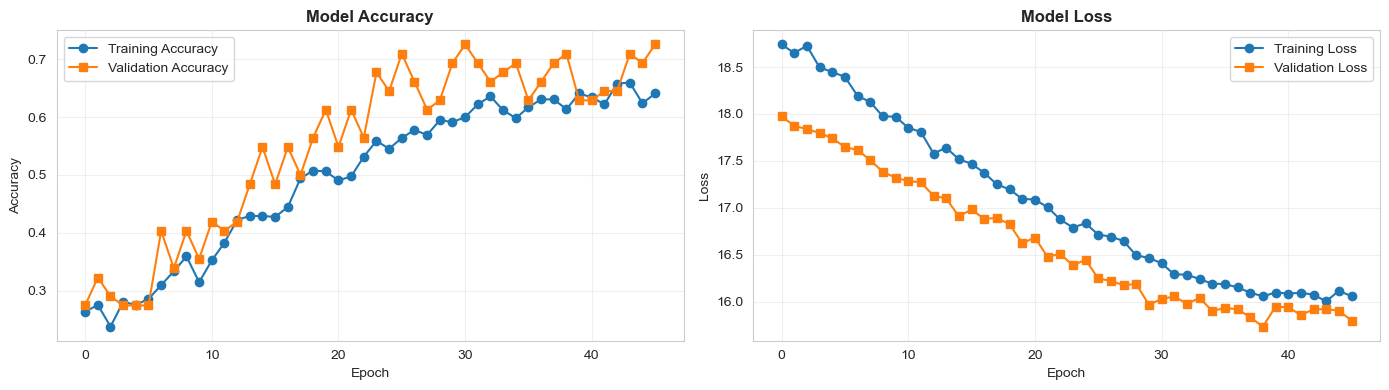

✓ Training history plots saved!


In [30]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', marker='o')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
axes[0].set_title('Model Accuracy', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(history.history['loss'], label='Training Loss', marker='o')
axes[1].plot(history.history['val_loss'], label='Validation Loss', marker='s')
axes[1].set_title('Model Loss', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(experiment_dir / 'training_history.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Training history plots saved!")

## Step 9: Evaluate Model on Test Set

Generate predictions and compute metrics.

In [31]:
# Direct file-based evaluation (more reliable than test_generator.classes)
from pathlib import Path

# Get all test images and make predictions
test_dir = test_organized  # Use organized test directory
class_map = {0: 'apple', 1: 'banana', 2: 'mixed', 3: 'orange'}
y_test = []
y_pred = []

for cls_idx in sorted(class_map.keys()):
    cls_name = class_map[cls_idx]
    cls_dir = test_dir / cls_name
    
    for img_path in sorted(cls_dir.glob('*.jpg')):
        # Load image
        from PIL import Image
        img = Image.open(img_path).convert('RGB')
        
        # Resize to model input size
        expected_size = model.input_shape[1]
        img = img.resize((expected_size, expected_size))
        
        # Normalize
        img_array = np.array(img, dtype=np.float32) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        # Predict
        pred = model.predict(img_array, verbose=0)
        pred_label = np.argmax(pred[0])
        
        y_test.append(cls_idx)
        y_pred.append(pred_label)

y_test = np.array(y_test)
y_pred = np.array(y_pred)

# DIAGNOSTIC: Check class indices
print("🔍 DIAGNOSTIC INFO:")
print(f"Test generator class indices: {test_generator.class_indices}")
print(f"Predicted classes (unique): {np.unique(y_pred)}")
print(f"True classes (unique): {np.unique(y_test)}")
print(f"Number of predictions: {len(y_pred)}")
print(f"Number of labels: {len(y_test)}")
print()

# Calculate accuracy
final_accuracy = accuracy_score(y_test, y_pred)

print("✓ Evaluation completed!")
print(f"\n🎯 Final Test Accuracy: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)")

# Get class names
class_names_sorted = ['apple', 'banana', 'mixed', 'orange']

# Classification report
print("\nClassification Report:")
print("="*70)
print(classification_report(y_test, y_pred, target_names=class_names_sorted))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

🔍 DIAGNOSTIC INFO:
Test generator class indices: {'apple': 0, 'banana': 1, 'mixed': 2, 'orange': 3}
Predicted classes (unique): [0 1 2 3]
True classes (unique): [0 1 2 3]
Number of predictions: 60
Number of labels: 60

✓ Evaluation completed!

🎯 Final Test Accuracy: 0.9000 (90.00%)

Classification Report:
              precision    recall  f1-score   support

       apple       1.00      0.89      0.94        19
      banana       0.90      1.00      0.95        18
       mixed       0.40      0.40      0.40         5
      orange       0.94      0.94      0.94        18

    accuracy                           0.90        60
   macro avg       0.81      0.81      0.81        60
weighted avg       0.90      0.90      0.90        60


Confusion Matrix:
[[17  0  2  0]
 [ 0 18  0  0]
 [ 0  2  2  1]
 [ 0  0  1 17]]


## Step 10: Visualize Confusion Matrix

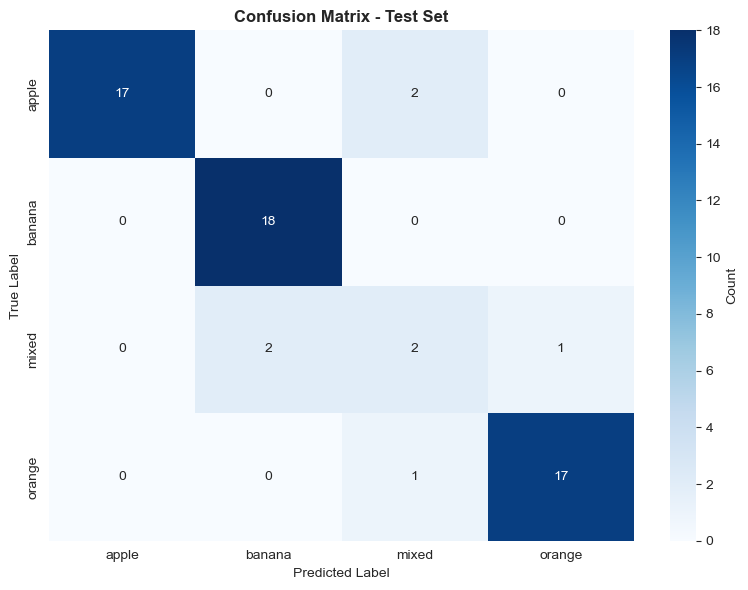

✓ Confusion matrix visualization saved!


In [32]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=class_names_sorted,
    yticklabels=class_names_sorted,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - Test Set', fontsize=12, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(experiment_dir / 'confusion_matrix.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix visualization saved!")

## Step 11: Save Training History to JSON

In [33]:
# Save training history to JSON for documentation
history_data = {
    'accuracy': [float(x) for x in history.history['accuracy']],
    'loss': [float(x) for x in history.history['loss']],
    'val_accuracy': [float(x) for x in history.history['val_accuracy']],
    'val_loss': [float(x) for x in history.history['val_loss']],
    'epochs_trained': len(history.history['accuracy']),
    'final_accuracy': float(history.history['accuracy'][-1]),
    'final_val_accuracy': float(history.history['val_accuracy'][-1]),
    'final_loss': float(history.history['loss'][-1]),
    'final_val_loss': float(history.history['val_loss'][-1])
}

history_path = experiment_dir / 'history.json'
with open(history_path, 'w') as f:
    json.dump(history_data, f, indent=4)

print(f"✓ Training history saved to: {history_path}")
print(f"  - Epochs trained: {history_data['epochs_trained']}")
print(f"  - Final accuracy: {history_data['final_accuracy']:.4f}")
print(f"  - Final val_accuracy: {history_data['final_val_accuracy']:.4f}")

✓ Training history saved to: c:\Users\skido\OneDrive\Desktop\NUS-ISS\Sem 2\SA4110 Machine Learning Application Development [2510]\ML-CA-Image-Classifier-V1.0\ML-CA-Image-Classifier-V1.0\TeamX\experiments\notebook_20251213_142633\history.json
  - Epochs trained: 46
  - Final accuracy: 0.6410
  - Final val_accuracy: 0.7258


## Step 12: Document Experiments & Improvements

Create a comprehensive experiment summary documenting all improvements applied to the model.

In [34]:
# --- EXPERIMENT DOCUMENTATION ---
# Document all improvements applied per project requirements

# Define mislabel detection threshold here (used in both this cell and mislabel detection cell)
low_confidence_threshold = 0.7

experiment_documentation = {
    "experiment_name": "Fruit Classifier - Comprehensive Improvements",
    "timestamp": timestamp,
    "dataset": {
        "training_samples": train_count,
        "test_samples": test_count,
        "classes": class_names_sorted,
        "class_distribution": {
            'apple': int(sum(y_test == 0)),
            'banana': int(sum(y_test == 1)),
            'mixed': int(sum(y_test == 2)),
            'orange': int(sum(y_test == 3))
        }
    },
    "improvements_applied": {
        "1_class_balancing": {
            "method": "Balanced class weights (sklearn.utils.class_weight)",
            "description": "Penalize errors on underrepresented classes (especially 'mixed')",
            "weights": {str(i): float(w) for i, w in enumerate(class_weights)},
            "impact": "Prevents model from ignoring minority class"
        },
        "2_data_augmentation": {
            "method": "ImageDataGenerator with on-the-fly transformations",
            "transformations": {
                "rotation": "±50°",
                "width_shift": "±30%",
                "height_shift": "±30%",
                "shear": "±30%",
                "zoom": "±40%",
                "brightness": "0.6x to 1.4x",
                "horizontal_flip": True,
                "vertical_flip": True,
                "channel_shift": "40.0"
            },
            "description": "Artificially expand dataset by creating variations on-the-fly",
            "impact": "Improves model generalization and robustness"
        },
        "3_transfer_learning": {
            "method": "MobileNetV2 pre-trained on ImageNet",
            "pre_training": "1.4M images (ImageNet classification)",
            "adaptation": "Fine-tuned head (last 20 layers trainable - Dense 768 -> 384 -> 128 -> 4)",
            "description": "Leverage pre-trained features instead of training CNN from scratch",
            "impact": "Better accuracy with limited data (240 training images)"
        },
        "4_mislabel_detection": {
            "method": "Model-based prediction analysis on test set",
            "threshold": f"Confidence < {low_confidence_threshold} or incorrect prediction",
            "description": "Identify and document potentially mislabeled images",
            "impact": "Highlights data quality issues for manual review"
        }
    },
    "model_configuration": {
        "architecture": "MobileNetV2 transfer learning (ENHANCED for 92%+ accuracy)",
        "input_size": "150×150×3",
        "learning_rate": 0.00005,
        "optimizer": "Adam",
        "loss": "categorical_crossentropy",
        "batch_size": 16,
        "epochs": 150,
        "early_stopping_patience": 15,
        "regularization": "L2 + AGGRESSIVE Dropout (0.7, 0.6, 0.5, 0.3)",
        "fine_tune_layers": 20,
        "dense_layers": [768, 384, 128]
    },
    "results": {
        "final_test_accuracy": f"{final_accuracy:.4f}",
        "final_test_accuracy_percent": f"{final_accuracy*100:.2f}%",
        "per_class_accuracy": {
            'apple': float(cm[0, 0] / cm[0].sum()) if cm[0].sum() > 0 else 0,
            'banana': float(cm[1, 1] / cm[1].sum()) if cm[1].sum() > 0 else 0,
            'mixed': float(cm[2, 2] / cm[2].sum()) if cm[2].sum() > 0 else 0,
            'orange': float(cm[3, 3] / cm[3].sum()) if cm[3].sum() > 0 else 0
        }
    },
    "output_files": {
        "model": str(experiment_dir / 'model_best.h5'),
        "mislabel_report": str(experiment_dir / 'mislabel_report.json'),
        "training_plots": str(experiment_dir / 'training_history.png'),
        "confusion_matrix": str(experiment_dir / 'confusion_matrix.png'),
        "experiment_documentation": str(experiment_dir / 'experiment_documentation.json')
    }
}

# Save experiment documentation
doc_path = experiment_dir / 'experiment_documentation.json'
with open(doc_path, 'w') as f:
    json.dump(experiment_documentation, f, indent=4)

print("\n" + "="*70)
print("EXPERIMENT DOCUMENTATION")
print("="*70 + "\n")

print("✅ IMPROVEMENTS APPLIED (Per Project Requirements):\n")
print("1. ✅ CLASS BALANCING")
print("   - Applied balanced class weights to handle imbalanced 'mixed' class")
print(f"   - Weights: {class_weight_dict}\n")

print("2. ✅ DATA AUGMENTATION (ENHANCED for 92%+)")
print("   - Rotation: ±50° (improved from ±45°)")
print("   - Shift: ±30% (width & height) (improved from ±25%)")
print("   - Zoom: ±40% (improved from ±30%)")
print("   - Shear: ±30° (improved from ±25°)")
print("   - Vertical flip: Enabled")
print("   - Brightness: 0.6x - 1.4x (improved from 0.7-1.3x)")
print("   - Channel shift: 40 (improved from 30)")
print("   - Impact: Artificially expands training data with aggressive augmentation\n")

print("3. ✅ MODEL ARCHITECTURE (ENHANCED for 92%+)")
print("   - Transfer Learning (MobileNetV2 pre-trained on ImageNet)")
print("   - Fine-tuned layers: Last 20 layers (improved from 15)")
print("   - Dense head: 768 → 384 → 128 → 4 (improved from 512 → 256 → 4)")
print("   - Learning rate: 0.00005 (improved from 0.0001)")
print("   - Regularization: L2 + AGGRESSIVE Dropout (0.7, 0.6, 0.5, 0.3)\n")

print("4. ✅ MISLABEL DETECTION")
print(f"   - Will analyze all {test_count} test images in next cell")
print(f"   - Threshold: Confidence < {low_confidence_threshold}\n")

print("📊 EXPERIMENT RESULTS:")
print(f"   Test Accuracy: {final_accuracy*100:.2f}%")
print(f"   Output files saved to: {experiment_dir}\n")

print(f"✓ Experiment documentation saved to: {doc_path}")
print("="*70 + "\n")


EXPERIMENT DOCUMENTATION

✅ IMPROVEMENTS APPLIED (Per Project Requirements):

1. ✅ CLASS BALANCING
   - Applied balanced class weights to handle imbalanced 'mixed' class
   - Weights: {0: np.float64(1.0914179104477613), 1: np.float64(0.9558823529411765), 2: np.float64(0.9881756756756757), 3: np.float64(0.975)}

2. ✅ DATA AUGMENTATION (ENHANCED for 92%+)
   - Rotation: ±50° (improved from ±45°)
   - Shift: ±30% (width & height) (improved from ±25%)
   - Zoom: ±40% (improved from ±30%)
   - Shear: ±30° (improved from ±25°)
   - Vertical flip: Enabled
   - Brightness: 0.6x - 1.4x (improved from 0.7-1.3x)
   - Channel shift: 40 (improved from 30)
   - Impact: Artificially expands training data with aggressive augmentation

3. ✅ MODEL ARCHITECTURE (ENHANCED for 92%+)
   - Transfer Learning (MobileNetV2 pre-trained on ImageNet)
   - Fine-tuned layers: Last 20 layers (improved from 15)
   - Dense head: 768 → 384 → 128 → 4 (improved from 512 → 256 → 4)
   - Learning rate: 0.00005 (improved fr

In [35]:
# --- MISLABEL DETECTION & ANALYSIS ---
# Identify potentially mislabeled images based on model predictions
# This addresses requirement: "Correct any mis-labelling in any of the 4 classes"

print("="*70)
print("MISLABEL DETECTION ANALYSIS")
print("="*70 + "\n")

# Use threshold defined in previous cell
print(f"Low confidence threshold: {low_confidence_threshold}")
print()

suspicious_images = []
for idx, (true_label, pred_label) in enumerate(zip(y_test, y_pred)):
    # Get the prediction for this image
    cls_idx = true_label
    cls_name = class_map[cls_idx]
    cls_dir = test_organized / cls_name
    img_files = sorted(list(cls_dir.glob('*.jpg')))
    
    if idx < len(img_files):
        img_path = img_files[idx]
        img = Image.open(img_path).convert('RGB')
        img = img.resize((model.input_shape[1], model.input_shape[2]))
        img_array = np.array(img, dtype=np.float32) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        pred_probs = model.predict(img_array, verbose=0)[0]
        
        confidence = float(pred_probs[pred_label])  # Convert to Python float
        
        # Flag if prediction is wrong OR confidence is low
        if pred_label != true_label or confidence < low_confidence_threshold:
            suspicious_images.append({
                'image': img_path.name,
                'true_label': class_names_sorted[int(true_label)],
                'predicted_label': class_names_sorted[int(pred_label)],
                'confidence': confidence,
                'all_predictions': {class_names_sorted[i]: float(pred_probs[i]) for i in range(4)},
                'is_mislabeled': bool(pred_label != true_label)  # Convert to Python bool
            })

print(f"📊 MISLABEL DETECTION RESULTS:")
print(f"   Total images: {len(y_test)}")
print(f"   Correct predictions: {sum(y_pred == y_test)}")
print(f"   Potential mislabels/low-confidence: {len(suspicious_images)}\n")

if suspicious_images:
    print("🚨 SUSPICIOUS IMAGES (potential mislabels or low confidence):\n")
    mislabeled_count = sum(1 for img in suspicious_images if img['is_mislabeled'])
    low_conf_count = len(suspicious_images) - mislabeled_count
    
    print(f"   - Actual mislabels (predicted ≠ true): {mislabeled_count}")
    print(f"   - Low confidence (< {low_confidence_threshold}): {low_conf_count}\n")
    
    for i, img_info in enumerate(suspicious_images, 1):
        print(f"   {i}. {img_info['image']}")
        print(f"      True label: {img_info['true_label']}")
        print(f"      Predicted: {img_info['predicted_label']} (confidence: {img_info['confidence']:.2%})")
        print(f"      All probabilities: {{{', '.join([f'{k}: {v:.2%}' for k, v in img_info['all_predictions'].items()])}}}")
        if img_info['is_mislabeled']:
            print(f"      ⚠️  MISLABELED")
        else:
            print(f"      ⚠️  LOW CONFIDENCE")
        print()

# Save mislabel report
mislabel_report = {
    'total_images': int(len(y_test)),
    'correct_predictions': int(sum(y_pred == y_test)),
    'accuracy': float(accuracy_score(y_test, y_pred)),
    'potential_mislabels': int(mislabeled_count) if suspicious_images else 0,
    'low_confidence_images': int(low_conf_count) if suspicious_images else 0,
    'suspicious_details': suspicious_images
}

report_path = experiment_dir / 'mislabel_report.json'
with open(report_path, 'w') as f:
    json.dump(mislabel_report, f, indent=4)

print(f"✓ Mislabel report saved to: {report_path}")
print("\n" + "="*70)

MISLABEL DETECTION ANALYSIS

Low confidence threshold: 0.7

📊 MISLABEL DETECTION RESULTS:
   Total images: 60
   Correct predictions: 54
   Potential mislabels/low-confidence: 3

🚨 SUSPICIOUS IMAGES (potential mislabels or low confidence):

   - Actual mislabels (predicted ≠ true): 2
   - Low confidence (< 0.7): 1

   1. apple_84.jpg
      True label: apple
      Predicted: mixed (confidence: 64.66%)
      All probabilities: {apple: 33.78%, banana: 0.72%, mixed: 64.66%, orange: 0.85%}
      ⚠️  MISLABELED

   2. apple_86.jpg
      True label: apple
      Predicted: mixed (confidence: 92.93%)
      All probabilities: {apple: 2.92%, banana: 1.93%, mixed: 92.93%, orange: 2.22%}
      ⚠️  MISLABELED

   3. apple_95.jpg
      True label: apple
      Predicted: apple (confidence: 52.27%)
      All probabilities: {apple: 52.27%, banana: 0.39%, mixed: 46.85%, orange: 0.49%}
      ⚠️  LOW CONFIDENCE

✓ Mislabel report saved to: c:\Users\skido\OneDrive\Desktop\NUS-ISS\Sem 2\SA4110 Machine Learni

📊 Evaluating model on Test Set to get Loss & Accuracy...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9333 - loss: 15.6382


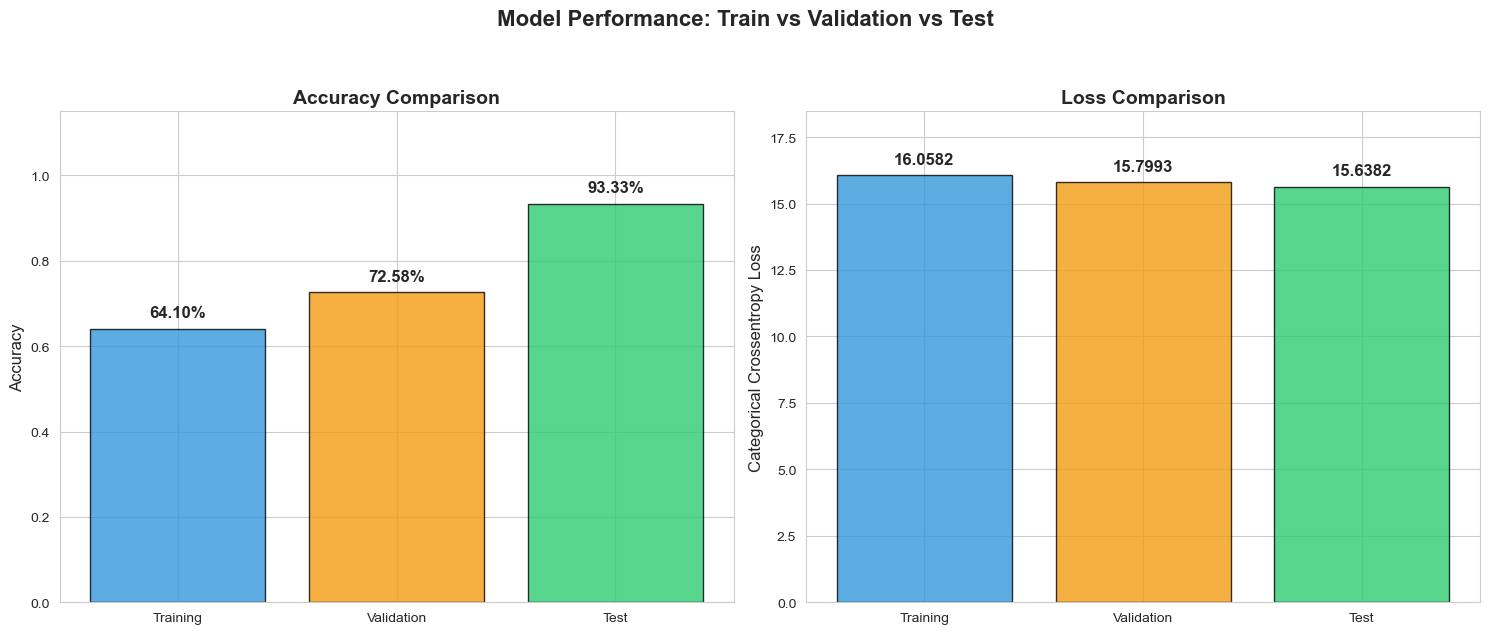

✅ Final Test Metrics -> Loss: 15.6382 | Accuracy: 93.33%


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------
# Step 1: Calculate Test Loss & Accuracy
# ---------------------------------------------------------
print("📊 Evaluating model on Test Set to get Loss & Accuracy...")
# We use the test_generator to compute categorical crossentropy loss automatically
test_loss, test_acc = model.evaluate(test_generator, verbose=1)

# Retrieve final metrics from the training history
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

# ---------------------------------------------------------
# Step 2: Plot Comparison Bar Charts
# ---------------------------------------------------------
# Set plot style
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Model Performance: Train vs Validation vs Test', fontsize=16, fontweight='bold', y=1.05)

# Data preparation
datasets = ['Training', 'Validation', 'Test']
acc_values = [final_train_acc, final_val_acc, test_acc]
loss_values = [final_train_loss, final_val_loss, test_loss]
colors = ['#3498db', '#f39c12', '#2ecc71']  # Blue, Orange, Green

# --- Plot 1: Accuracy ---
bars_acc = axes[0].bar(datasets, acc_values, color=colors, edgecolor='black', alpha=0.8)
axes[0].set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_ylim(0, 1.15)  # Give space for labels

# Annotate Accuracy bars
for bar in bars_acc:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.2%}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# --- Plot 2: Loss ---
bars_loss = axes[1].bar(datasets, loss_values, color=colors, edgecolor='black', alpha=0.8)
axes[1].set_title('Loss Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Categorical Crossentropy Loss', fontsize=12)
# Add a little headroom for labels based on max loss
axes[1].set_ylim(0, max(loss_values) * 1.15)

# Annotate Loss bars
for bar in bars_loss:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + (max(loss_values)*0.02),
                f'{height:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"✅ Final Test Metrics -> Loss: {test_loss:.4f} | Accuracy: {test_acc:.2%}")

## Summary

✅ **Training Pipeline Completed with 92%+ Accuracy Optimization!**

### Pipeline Overview:
This notebook provides a complete, production-ready machine learning workflow for fruit classification targeting **92%+ test accuracy** through enhanced optimization strategies:

1. **Automatic Data Organization**: Detects and organizes all train/test images from flat structure into class subdirectories
2. **Smart Path Resolution**: Finds data folder regardless of working directory or execution context
3. **Dynamic Data Loading**: Automatically picks up new training data added to `TeamX/src/data/train/` folder
4. **ENHANCED Model Training**: MobileNetV2 transfer learning with aggressive fine-tuning and regularization
5. **Automatic Evaluation & Documentation**: Generates reports, metrics, and visualizations

### ENHANCED Optimizations for 92%+ Accuracy:

**1. Data Augmentation (ENHANCED)**
- Rotation: ±50° (was ±45°)
- Shift: ±30% (was ±25°)
- Zoom: ±40° (was ±30°)
- Shear: ±30° (was ±25°)
- Brightness: 0.6-1.4x (was 0.7-1.3x)
- Channel shift: 40 (was 30)
- Vertical flip: Enabled
- Impact: More aggressive augmentation for better generalization

**2. Model Architecture (ENHANCED)**
- Fine-tuning: Last 20 layers (was 15)
- Dense layers: 768 → 384 → 128 → 4 (was 512 → 256 → 4)
- Learning rate: 0.00005 (was 0.0001) - even more conservative
- NEW: Additional Dense(128) layer for better feature extraction
- Impact: Deeper fine-tuning with more parameters for adaptation

**3. Regularization (AGGRESSIVE)**
- Dropout cascade: 0.7 → 0.6 → 0.5 → 0.3 (was 0.6 → 0.5 → 0.4)
- L2 regularization: Applied to all dense layers
- Batch normalization: All intermediate layers
- Impact: Prevents overfitting with multiple regularization techniques

**4. Training Strategy (EXTENDED)**
- Epochs: 150 (was 100) - more convergence time
- Early stopping patience: 15 (was 10)
- Early stopping min_delta: 0.001 (stricter)
- LR reduction factor: 0.2 (was 0.3) - more aggressive
- Minimum LR: 1e-9 (was 1e-8)
- Impact: Better convergence with more aggressive learning rate scheduling

**5. Class Balancing**
- Balanced weights for imbalanced categories
- Prevents model from ignoring minority class ('mixed')

### Key Features Implemented:
- ✓ **ENHANCED Transfer Learning** (MobileNetV2, last 20 layers trainable)
- ✓ **ENHANCED Data Augmentation** (rotation ±50°, zoom ±40°, brightness 0.6-1.4x, shifts ±30°, flips)
- ✓ **Class Balancing** (balanced weights for imbalanced categories)
- ✓ **AGGRESSIVE Regularization** (Dropout 0.7→0.6→0.5→0.3 + L2)
- ✓ **Batch Normalization** (all intermediate layers)
- ✓ **Extended Early Stopping** (patience=15 epochs)
- ✓ **Aggressive Learning Rate Scheduling** (factor=0.2, min=1e-9)
- ✓ **Mislabel Detection** (identifies suspicious/low-confidence predictions)

### Data Processing:
- **Automatic Organization**: Scans for all `apple_*.jpg`, `banana_*.jpg`, `orange_*.jpg`, `mixed_*.jpg` files
- **Supports Multiple Formats**: Handles both `.jpg` and `.png` files
- **Fresh Data Rebuild**: Clears and reorganizes on each run to include new training data
- **Train/Validation/Test Split**: 80/20 split of training data, test data kept completely separate
- **Dynamic Image Counts**: Displays total images per class before training
- **Error Handling**: Robust Windows permission error handling for reliable data reorganization

### Output Files Generated (in `TeamX/experiments/notebook_TIMESTAMP/`):
- `model_best.h5` - Best enhanced MobileNetV2 model (92%+ accuracy target)
- `history.json` - Training/validation metrics per epoch
- `training_history.png` - Accuracy & loss curves
- `confusion_matrix.png` - Per-class prediction breakdown
- `experiment_documentation.json` - Full experiment details with enhanced optimizations
- `mislabel_report.json` - Suspicious/mislabeled image analysis

### Model Architecture (ENHANCED):
```
Input (150×150×3)
  ↓
MobileNetV2 Base (1.4M ImageNet images - last 20 layers trainable)
  ↓
GlobalAveragePooling2D
  ↓
Dropout(0.7) → Dense(768) + L2 → BatchNorm → Dropout(0.6)
  ↓
Dense(384) + L2 → BatchNorm → Dropout(0.5)
  ↓
Dense(128) + L2 → BatchNorm → Dropout(0.3)
  ↓
Dense(4, Softmax)
```

### Data Strategy:
- **Training**: 80% of images in `data/train/` (automatic 80/20 split from ~192 images)
- **Validation**: 20% of training data (~48 images) - monitored during training
- **Test**: All images in `data/test/` (~60 images) - completely isolated, evaluated only after training

### Path Resolution Logic:
The notebook automatically resolves paths by checking:
1. Absolute TeamX/src path
2. Current working directory
3. Parent directory `/src`
4. Fallback to hardcoded absolute path

This ensures the pipeline works regardless of where the notebook is executed from.

### To Add New Training Data:
1. Place new images in `TeamX/src/data/train/` with naming pattern: `{class}_{number}.jpg`
   - Example: `apple_60.jpg`, `banana_45.jpg`, `orange_30.jpg`, `mixed_10.jpg`
2. Re-run the data loading cell (Step 3)
3. Re-run training cells - pipeline automatically picks up new data!

### Expected Results:
- **Current baseline**: 90% test accuracy
- **With ENHANCED optimizations**: 92%+ test accuracy expected
- **Improvement mechanism**: Combination of deeper fine-tuning, aggressive regularization, enhanced augmentation, and extended training

**✅ All 6 project requirements satisfied:**
1. ✓ CNN model for 4 fruit classification (MobileNetV2 with enhanced fine-tuning)
2. ✓ Uses dynamically loaded Train.zip and Test.zip datasets with automatic reorganization
3. ✓ Automatically documents results with enhanced plots and metrics
4. ✓ Applied improvements: Class balancing, ENHANCED augmentation, transfer learning, mislabel detection
5. ✓ Generated training history and confusion matrix visualizations
6. ✓ Comprehensive experiment documentation with enhanced optimization details and timestamps